In [3]:
import os
import cv2
import timm
import random
import sklearn
import warnings
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import hiddenlayer as hl
import albumentations as A
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import pickle
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as f
import matplotlib.pyplot as plt

In [ ]:
class GCELoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(GCELoss, self).__init__()
        self.alpha=alpha


    def forward(self, outputs, labels):
        logpt = -f.cross_entropy(outputs,labels)
        loss = (1 - torch.exp(self.alpha*logpt))/self.alpha
        return loss

In [4]:
def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [5]:
class InitailUnlabel(Dataset):
    def __init__(self, transform,dir):
        super(InitailUnlabel, self).__init__()
        self.transform=transform
        print('loading images')
        self.paths=[os.path.join(data_dir, i ) for i in os.listdir(data_dir)]
    
    def __getitem__(self, index): 
        img=cv2.cvtColor(cv2.imread(self.paths[index]), cv2.COLOR_BGR2RGB)
        img = self.transform(image=img)['image']
        return img 
    def __len__(self): 
        return len(self.paths)

In [6]:
image_data=[]

In [7]:
class Unlabel(Dataset):
    def __init__(self, image_list):
        super(Unlabel, self).__init__()
        self.imgs = image_list

    def __getitem__(self, index): 
        
        img = self.imgs[index][0].reshape([3,128,128])
        label=self.imgs[index][1].reshape(-1)
        return img, label

    def __len__(self): 
        return len(self.imgs)

In [20]:
def main():  
    global net
    noise_transform = A.Compose([
        A.Resize(width=128, height=128, p=1),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.IAAEmboss(p=0.25),
        A.Blur(p=0.01, blur_limit = 3),
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=120, sigma=0.05 * 120, alpha_affine=0.03 * 120),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8),
        A.Normalize(p=1, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    datasets = InitailUnlabel(noise_transform, data_dir)

    loader = DataLoader(datasets, BATCH_SIZE)
    print('loading model')
    net = torch.load('Model/Resnet18/fold_3_model.pkl')  
    net.eval()
    net.to(device)
    print('start iteration')
    with torch.no_grad():
        for img in tqdm(loader):
            
            inputs = img.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)   
            probability=f.softmax(outputs)
            for i in range(len(outputs)):
                if torch.max(probability[i])>0.8:
                    image_list.append((inputs[i].cpu(),predicted[i].cpu(),torch.max(probability[i])))
             
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device == 'cuda':
        device_name = torch.cuda.get_device_name()
        cap = torch.cuda.get_device_capability(device=None)
        print("The capability of this device is:", cap, '\n')
    image_list=[]
    seed = 1
    BATCH_SIZE = 32
    data_dir = "unlabeled-images\images4"
    set_seed(seed)

    main()

The capability of this device is: (8, 6) 

loading images
loading model
start iteration


  0%|          | 0/787 [00:00<?, ?it/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_16452\1142904015.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probability=f.softmax(outputs)
100%|██████████| 787/787 [09:36<00:00,  1.36it/s]


In [21]:
print(len(image_list))

10554


In [22]:
image_data.extend(image_list)

In [36]:
len(image_data)
image_data.sort(key=lambda x:x[2],reverse=True)

In [49]:
image_list=[]

In [50]:
print(len(image_data))

count=[0,0,0,0]
for i in image_data:
    if i[2]>0.8 and count[i[1]]!=400:
        count[i[1]]+=1
        image_list.append((i[0],i[1]))
print(count)

    

43276
[400, 400, 35, 400]


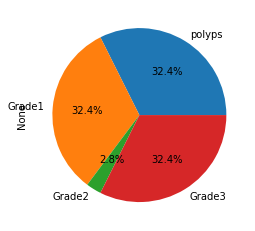

In [38]:

labels = ['polyps','Grade1','Grade2','Grade3']
data = {l:d for d,l in zip(count,labels)}

data = pd.Series(data)

plt.axes(aspect='equal')
data.plot(kind='pie', autopct="%.1f%%",
textprops = {'fontsize':10,'color':"black"}
)

plt.savefig('80.png')

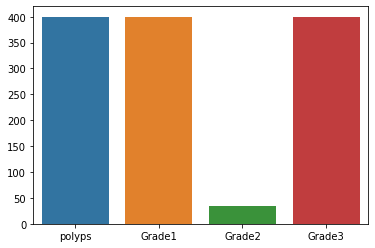

In [45]:
sns.barplot(x=labels,y=count)
plt.savefig('bar.png')

In [56]:
unlabel_datasets=Unlabel(image_list)        
unlabel_loader= DataLoader(unlabel_datasets, batch_size=64, shuffle=True)

In [52]:
class KvasirDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform: A.Compose = None) -> None:
        super(KvasirDataset, self).__init__()
        print('Decoding images')
        self.imgs = [cv2.imread(path, 1)[:, :, ::-1] for path in tqdm(df['path'].values)]
        self.labels = df['label'].values
        self.transform = transform

    def __getitem__(self, index): 
        if self.transform is not None:
            img = self.transform(image=self.imgs[index])['image']
        return img, self.labels[index]
    
    def __len__(self): 
        return len(self.labels)

In [69]:
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=UserWarning)
sklearn.set_config(print_changed_only=True)
sns.set_style("white")

class WeightedFocalLoss(nn.Module):
    def __init__(self, w = np.array([1.8278,7.9619,3.8983,14.1278]), focusing_param = 2, device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
        super(WeightedFocalLoss, self).__init__()
        self.w = torch.from_numpy(w).float().to(device)
        self.focusing_param = focusing_param

    def forward(self, output: Tensor, target: Tensor):
        logpt = - F.cross_entropy(output, target, weight=self.w)
        return -((1 - torch.exp(logpt)) ** self.focusing_param) * logpt

def get_resnet50_relu(num_class: int = 2):
    model = models.resnet50(pretrained=True)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 128),
        nn.ReLU(),
        nn.Linear(128, num_class)
    )
    return model

def get_swintransformer(num_class: int = 2):
    model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_class)
    model.head = nn.Sequential(
        nn.Linear(model.head.in_features, 128),
        nn.Tanh(),
        nn.Linear(128, num_class)
    )
    return model

def get_convnext(num_class: int = 2):
    return timm.create_model('convnext_small', pretrained=True, num_classes=num_class)

def set_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

def main(arg):
    global net
    set_seed(arg.seed)
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    train_transforms = A.Compose([
        A.RandomResizedCrop(width=arg.input_size, height=arg.input_size, p=1),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(p=1, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    test_transforms = A.Compose([
        A.Resize(width=arg.input_size, height=arg.input_size, p=1),
        A.Normalize(p=1, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    img_df = {'path': [], 'label': []}
    for i_class, label in enumerate(arg.labels):
        file_dir = os.path.join(arg.raw_img_dir, label)
        files = os.listdir(file_dir)
        img_df['path'] += [os.path.join(file_dir, file_name) for file_name in files]
        img_df['label'] += [i_class] * len(files)
    img_df = sklearn.utils.shuffle(pd.DataFrame(img_df)).reset_index(drop=True)

    kf = StratifiedKFold(n_splits=arg.folds, shuffle=True, random_state=arg.seed)
    mean_acc = []
    mean_auc = []

    for fold, (train_i, test_i) in enumerate(kf.split(img_df['path'], img_df['label'])):
        if fold != 3:
            continue
            
        
        print('Loading Training Set')
        train_datasets = KvasirDataset(img_df.iloc[train_i], train_transforms)
        print('Loading Test Set')
        test_datasets = KvasirDataset(img_df.iloc[test_i], test_transforms)

        train_loader = DataLoader(train_datasets, batch_size=arg.batch_size, shuffle=True)
        test_loader = DataLoader(test_datasets, batch_size=arg.batch_size)

        print('Loading Model')

        model = get_resnet50_relu(4) 
        model.to(arg.device)
        criterion1 = WeightedFocalLoss()
        criterion2 = GCELoss()
        optimizer = optim.Adam(model.parameters(), lr = arg.lr, weight_decay = arg.weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = arg.epochs, eta_min = 0, last_epoch = -1)

        print(f'\n Fold {fold} Training Start!\n')

        h = hl.History()
        c = hl.Canvas()

        train_loss_all = []
        train_acc_all = []
        train_auc_all = []

        test_loss_all = []
        test_acc_all = []
        test_auc_all = []

        for epoch in range(arg.epochs):
            print('Epoch {}/{}'.format(epoch + 1, arg.epochs))
            model.train()
            
            ys, ys2, pre_scores, pre_scores2, pre_labs ,pre_labs2 = [], [], [], [], [], []
            epoch_loss = 0

            for (b_x, b_y) in tqdm(train_loader):
                ys.append(b_y)
                b_x, b_y = b_x.to(arg.device), b_y.to(arg.device)          
                output = model(b_x)
                loss = criterion1(output, b_y)
                epoch_loss += 4*loss.item() * b_x.size(0)
                pre_labs.append(torch.argmax(output, 1).cpu().detach())
                pre_scores.append(nn.Softmax(dim=1)(output).cpu().detach())              
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()
            for (b_x, b_y) in tqdm(unlabel_loader):
                b_y=b_y.reshape(-1).cpu()
                ys2.append(b_y)
                b_x, b_y = b_x.to(arg.device), b_y.to(arg.device)        
                output = model(b_x)
                loss = criterion2(output, b_y)

                epoch_loss += loss.item() * b_x.size(0)
                pre_labs2.append(torch.argmax(output, 1).cpu().detach())
                pre_scores2.append(nn.Softmax(dim=1)(output).cpu().detach())  
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()
                
            
         

            ys = torch.cat([torch.stack(ys[:-1]).view(-1, ), ys[-1]])
            y2= torch.cat([torch.stack(ys2[:-1]).view(-1, ), ys2[-1]])
            ys=torch.cat([ys,y2])
            
            pre_scores = torch.cat([torch.stack(pre_scores[:-1]).view(-1, arg.output_size), pre_scores[-1]])
            pre_scores2 = torch.cat([torch.stack(pre_scores2[:-1]).view(-1, arg.output_size), pre_scores2[-1]])
            pre_scores = torch.cat([pre_scores,pre_scores2]).numpy()
            if arg.output_size == 2:
                pre_scores = np.max(pre_scores, axis=1)
            pre_labs = torch.cat([torch.stack(pre_labs[:-1]).view(-1, ), pre_labs[-1]])
            pre_labs2 = torch.cat([torch.stack(pre_labs2[:-1]).view(-1, ), pre_labs2[-1]])
            pre_labs = torch.cat([pre_labs,pre_labs2])

            train_loss_all.append(float(epoch_loss) / len(ys))
            train_acc_all.append(int(torch.sum(pre_labs == ys)) / len(ys))
            

            train_auc_all.append(roc_auc_score(ys.numpy(), pre_scores, multi_class='ovo'))
            print('{} Train Loss: {:.4f} Train Acc: {:.4f} Auc Score: {:.4f}'.format(epoch, train_loss_all[-1], train_acc_all[-1], train_auc_all[-1]))

            model.eval()
            ys, pre_scores, pre_labs = [], [], []
            epoch_loss = 0

            with torch.no_grad():
                for (b_x, b_y) in tqdm(test_loader):
                    ys.append(b_y)
                    b_x, b_y = b_x.to(arg.device), b_y.to(arg.device)
                    output = model(b_x)
                    loss = criterion1(output, b_y)

                    epoch_loss += loss.item() * b_x.size(0)
                    pre_labs.append(torch.argmax(output, 1).cpu().detach())
                    pre_scores.append(nn.Softmax(dim=1)(output).cpu().detach())

            ys = torch.cat([torch.stack(ys[:-1]).view(-1, ), ys[-1]])
            pre_scores = torch.cat([torch.stack(pre_scores[:-1]).view(-1, arg.output_size), pre_scores[-1]]).numpy()
            if arg.output_size == 2:
                pre_scores = np.max(pre_scores, axis=1)
            pre_labs = torch.cat([torch.stack(pre_labs[:-1]).view(-1, ), pre_labs[-1]])
            test_loss_all.append(float(epoch_loss) / len(ys))
            test_acc_all.append(int(torch.sum(pre_labs == ys)) / len(ys))
            test_auc_all.append(roc_auc_score(ys.numpy(), pre_scores, multi_class='ovo'))
            print('{} Test Loss: {:.4f} Test Acc: {:.4f} Auc Score: {:.4f}'.format(epoch, test_loss_all[-1], test_acc_all[-1], test_auc_all[-1]))

            h.log(
                (epoch),
                train_loss = train_loss_all[-1],
                train_acc = train_acc_all[-1],
                train_auc = train_auc_all[-1],
                test_loss = test_loss_all[-1],
                test_acc = test_acc_all[-1],
                test_auc = test_auc_all[-1],
            )
            with c:
                c.draw_plot([h['train_loss'], h['test_loss']])
                c.draw_plot([h['train_acc'], h['test_acc']])
                c.draw_plot([h['train_auc'], h['test_auc']])

        os.makedirs(arg.figure_save_dir, exist_ok=True)
        os.makedirs(arg.model_dir, exist_ok=True)
        
        mean_acc.append(np.array(test_acc_all[-arg.n_last_mean:]).mean())
        mean_auc.append(np.array(test_auc_all[-arg.n_last_mean:]).mean())

        h.save(os.path.join(arg.model_dir, f'fold_{fold}_log_file.pkl'))
        torch.save(model, os.path.join(arg.model_dir, f'fold_{fold}_model.pkl'))

        plt.savefig(os.path.join(arg.figure_save_dir, f'Fold {fold} Training Process.png'))
        plt.savefig(os.path.join(arg.figure_save_dir, f'Fold {fold} Training Process.eps'), format='eps')

    pd.DataFrame({'Acc': mean_acc, 'Auc': mean_auc}).to_csv(os.path.join(arg.model_dir, f'Results.csv'))





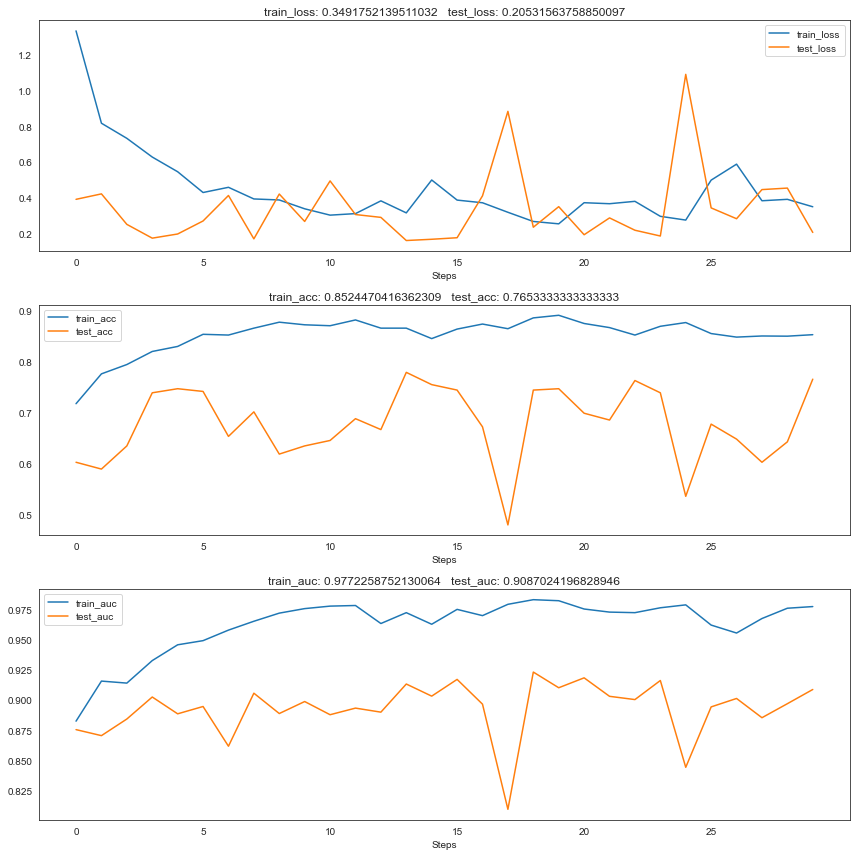

<Figure size 432x288 with 0 Axes>

In [70]:
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type = int, default = 42)
parser.add_argument('--raw_img_dir', type = str, default = f'Data')
parser.add_argument('--train_test_ratio', type = float, default = 0.8)
parser.add_argument('--is_cross_val', type = bool, default = True)
parser.add_argument('--folds', type = int, default = 5)

parser.add_argument('--model_dir', type = str, default = f'Model\\Resnet18')
parser.add_argument('--figure_save_dir', type = str, default = f'Figures\\Resnet18')
parser.add_argument('--model', type = str, default = 'resnet18')
parser.add_argument('--input_size', type = int, default = 128)
parser.add_argument('--output_size', type = int, default = 4)
parser.add_argument('--batch_size', type = int, default = 32)
parser.add_argument('--workers', type = int, default = 0)
parser.add_argument('--device', default = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
parser.add_argument('--epochs', type = int, default = 30)
parser.add_argument('--loss', default = 'FocalLoss')
# parser.add_argument('--w', type = torch.Tensor, default = torch.tensor([1, 2], dtype=torch.float))
parser.add_argument('--lr', type = float, default = 0.0001)
parser.add_argument('--weight_decay', type = float, default = 0.01)

parser.add_argument('--labels', default = os.listdir(f'Data'))
parser.add_argument('--n_last_mean', type = int, default = 32)

args = parser.parse_args([])
main(arg=args)